In [1]:
import os
import sys
import shutil
os.environ['TOKENIZERS_PARALLELISM'] = "False"

import torch
import pandas as pd
import numpy as np
import decord
import json
from torch.nn.functional import cosine_similarity
from utils.video import read_frames_decord
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

import shared.utils as su
from notebooks.eval_care_retrieval import load_model
from utils.video import read_frames_decord
from utils.model import transform_pixel_values
from torchvision.transforms.v2 import (
    ToPILImage,
)

### Load model

In [2]:
from models.modeling_encoders import AutoEncoder

# model_id = "/work/piyush/experiments/CaRe/Tarsier-7b/nli-9k+ego4d-1k/merged_checkpoint"
model_id = "/work/piyush/experiments/CaRe/Tarsier-7b/final-10112025/nli_9000+ego_1000+subj_replaced-seed_42/merged_checkpoint"

encoder = AutoEncoder.from_pretrained(model_id, device_map='cuda:0')
su.misc.num_params(encoder.model)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading EncoderForTarsier from /work/piyush/experiments/CaRe/Tarsier-7b/final-10112025/nli_9000+ego_1000+subj_replaced-seed_42/merged_checkpoint
### do_image_padding is set as False, images will be resized directly!


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
TarsierForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
You are attempting to use Flash Attention 2.

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

::: Number of total parameters in TarsierForConditionalGeneration: 7063.427M


### Generate captions for source videos

In [14]:
from models.modeling_captioners import AutoCaptioner
model_id = "/work/piyush/experiments/CaRe/Tarsier-7b/final-10112025/nli_9000+ego_1000+subj_replaced-seed_42/merged_checkpoint"
captioner = AutoCaptioner.from_pretrained(model_id, device_map='cuda:0')
su.misc.num_params(captioner.model)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading CaptionerForTarsier from /work/piyush/experiments/CaRe/Tarsier-7b/final-10112025/nli_9000+ego_1000+subj_replaced-seed_42/merged_checkpoint
### do_image_padding is set as False, images will be resized directly!


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

::: Number of total parameters in TarsierForConditionalGeneration: 7063.427M


In [17]:
video_path = "../../TimeBound.v1/sample_data/folding_paper.mp4"
video_tensor = read_frames_decord(video_path, 8)
with torch.no_grad():
    caption = captioner.describe(video_tensor.unsqueeze(0))[0]
print(video_path)
print(caption)

../../TimeBound.v1/sample_data/folding_paper.mp4
A hand is seen holding and slightly adjusting a white paper on a gray surface. The paper is opened and then closed again by the hand.


In [ ]:
iterator = su.log.tqdm_iterator(range(len(df)), desc='Generating captions')
captions = {}
for i in iterator:
    row = df.iloc[i].to_dict()
    video1 = row['video1_path']
    video_tensor = read_frames_decord(video1, 8)
    with torch.no_grad():
        caption = captioner.describe(video_tensor.unsqueeze(0))[0]
    captions[row['video1']] = caption
len(captions)

Generating captions:   0%|          | 0/2555 [00:00<?, ?it/s]

In [ ]:
su.io.save_pkl(captions, f"{data_dir}/generated_captions_query_videos.pkl")

In [26]:
len(captions)

2443

In [27]:
len(captions)


2443

### Load data

In [28]:
data_dir = "/scratch/shared/beegfs/piyush/datasets/WebVid-CoVR"
df = pd.read_csv(f"{data_dir}/webvid8m-covr_test-cleaned.csv")
print("Number of rows in CoVR-test: ", len(df))

df.iloc[0].to_dict()

video_dir = '/datasets/WebVid/videos'

df['video1_path'] = df['video1'].apply(lambda x: f"{video_dir}/{x}")
df['video2_path'] = df['video2'].apply(lambda x: f"{video_dir}/{x}")
df = df[df.video1_path.apply(os.path.exists) & df.video2_path.apply(os.path.exists)]
print("Number of rows with all videos available: ", df.shape)

d = set(df['video1_path']).intersection(set(df['video2_path']))

# Remove problematic videos
df = df[df.video1_path != '/datasets/WebVid/videos/108401_108450/6507308.mp4']

type(d), len(d)

Number of rows in CoVR-test:  2556
Number of rows with all videos available:  (2556, 11)


(set, 114)

#### Video durations

In [16]:
# Target video duration
from tqdm import tqdm
tqdm.pandas(desc='Gathering video durations')
df['video2_duration'] = df['video2_path'].progress_apply(lambda x: su.video.get_duration(x))

Gathering video durations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2556/2556 [00:21<00:00, 116.46it/s]


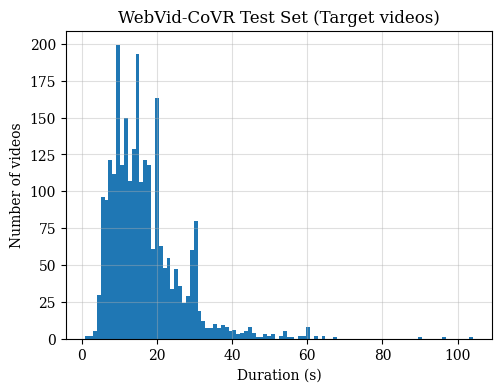

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))
ax.grid(alpha=0.4)
ax.hist(df.video2_duration.tolist(), bins=100)
ax.set_xlabel("Duration (s)")
ax.set_ylabel("Number of videos")
ax.set_title("WebVid-CoVR Test Set (Target videos)")
plt.show()

### Embed the queries

**1. Single frame**

In [29]:
def embed_query_single_frame(video_path, edit_text, video_caption=None, verbose=False):

    if video_caption is None:
        PROMPT = "Source video frame: <image>\nEdit instruction: <sent>\n"\
                 "This is the middle frame of a video. The provided text is instruction to edit the video. "\
                 "Imagine this edit instruction being applied to the provided video frame.\n"\
                 "Summarize the resulting edited video in one word:"
    else:
        PROMPT = f"Source video frame: <image>\nSource video caption: {video_caption}\n"\
                 "This is the middle frame of a video along with its caption.\n\n"\
                 "Edit instruction: <sent>\n"\
                 "The provided edit text is instruction to edit the video. "\
                 "Imagine this edit instruction being applied to the provided video frame.\n\n"\
                 "Summarize the resulting edited video in one word:"
    PROMPT = f"USER: {PROMPT} ASSISTANT: "

    # if verbose:
    #     print(PROMPT)

    generate_kwargs = {
        "max_new_tokens": 1,
        "output_hidden_states": True,
        "return_dict_in_generate": True,
    }

    decord.bridge.set_bridge('native')
    vr = decord.VideoReader(video_path, num_threads=1)
    mid = len(vr) // 2
    image = torch.from_numpy(vr[mid].asnumpy()).unsqueeze(0)
    image = image.permute(0, 3, 1, 2) # [T, C, H, W]

    # Prepare video
    # pixel_values = read_frames_decord(video_path, n_frames).unsqueeze(0)
    pixel_values = transform_pixel_values(image)
    nframes = pixel_values.shape[1]
    to_image = ToPILImage()
    batched_frames = []
    for batch in pixel_values:
        frames = [to_image(v) for v in batch]
        batched_frames.append(frames)

    for frames in batched_frames:

        # Video
        input_prompt = PROMPT.replace("<video>", "<image>"*len(frames))

        # Text
        input_prompt = input_prompt.replace('<sent>', edit_text)

        if verbose:
            print(input_prompt)
            print("-" * 120)

        input_ids = encoder.processor.get_text_inputs(input_prompt)
        frames = encoder.processor.get_pixel_values(frames)
        inputs = {
            "input_ids": input_ids,
            "pixel_values": frames
        }
        inputs = {k:v.to(encoder.model.device) for k,v in inputs.items() if v is not None}
        outputs = encoder.model.generate(
            **inputs,
            **generate_kwargs,
        )
        zv = outputs.hidden_states[0][-1][:, -1, :]
        break # Safe to break since it is just one video

    if verbose:
        print(zv.shape)

    return zv.squeeze(0)


i = 0
row = df.iloc[i].to_dict()
zv = embed_query_single_frame(
    row['video2_path'], row['edit'], verbose=True, video_caption=captions[row['video1']],
)
zv.shape

USER: Source video frame: <image>
Source video caption: The video clip starts with a black screen and gradually reveals white lines and dots that form intricate patterns and structures. The lines and dots increase in density and complexity over time, creating a network-like visual effect. The background remains consistently black throughout the clip.
This is the middle frame of a video along with its caption.

Edit instruction: replace the white lines and dots with green
The provided edit text is instruction to edit the video. Imagine this edit instruction being applied to the provided video frame.

Summarize the resulting edited video in one word: ASSISTANT: 
------------------------------------------------------------------------------------------------------------------------
torch.Size([1, 4096])


torch.Size([4096])

In [22]:
captions[row['video1']]

'A hand is seen holding and slightly adjusting a white paper on a gray surface. The paper is opened and then closed again by the hand.'

In [30]:
# Gather query embeddings
query_embeddings_single_frame_with_caption = {}
for i in su.log.tqdm_iterator(range(len(df)), desc="Compute query embeddings [single frame]"):
    row = df.iloc[i].to_dict()
    video_path = f"{video_dir}/{row['video1']}"
    edit_text = row['edit']
    with torch.no_grad():
        try:
            zv = embed_query_single_frame(video_path, edit_text, video_caption=captions[row['video1']])
        except:
            print(f"Failed {i}.")
            continue
        zv = torch.nn.functional.normalize(zv, dim=-1)
        zv = zv.cpu().float()
    key = f"{edit_text}|{row['video1']}"
    query_embeddings_single_frame_with_caption[key] = zv
len(query_embeddings_single_frame_with_caption)

Compute query embeddings [single frame]:   0%|          | 0/2555 [00:00<?, ?it/s]

2555

In [31]:
# torch.save(
# query_embeddings_single_frame_with_caption, f"{data_dir}/query_embeddings_single_frame_with_caption.pt")
# su.io.save_pkl(
# query_embeddings_single_frame_with_caption, f"{data_dir}/query_embeddings_single_frame_with_caption.pkl")
su.io.save_pkl(
    query_embeddings_single_frame_with_caption, f"{data_dir}/query_embeddings_single_frame_with_gen_caption.pkl"
)

**Embed candidate videos as usual**

In [54]:
from utils.video import read_frames_decord

videos = set(df.video2.tolist())
candidates = {}
n_frames = 15
for video in su.log.tqdm_iterator(videos, desc='Computing features for candidate videos'):
    video_path = f"{video_dir}/{video}"
    assert os.path.exists(video_path)
    try:
        video_tensor = read_frames_decord(video_path, n_frames)
        with torch.no_grad():
            zv = encoder.encode_vision(video_tensor.unsqueeze(0)).cpu().squeeze(0).float()
            zv = torch.nn.functional.normalize(zv, dim=-1)
        candidates[video] = zv
    except:
        print(f"Failed {i}.")
        continue

len(candidates)

Computing features for candidate videos:   0%|          | 0/2555 [00:00<?, ?it/s]

2555

In [61]:
su.io.save_pkl(candidates, f"{data_dir}/gallery_embeddings-nframes_15.pkl")

In [63]:
su.io.save_pkl(query_embeddings_single_frame, f"{data_dir}/query_embeddings_single_frame.pkl")

In [56]:
torch.save(candidates, f"{data_dir}/gallery_embeddings-nframes_15.pt")

[autoreload of transformers.models.conditional_detr failed: Traceback (most recent call last):
  File "/users/piyush/miniconda3/envs/carebench/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/users/piyush/miniconda3/envs/carebench/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/users/piyush/miniconda3/envs/carebench/lib/python3.10/importlib/__init__.py", line 139, in reload
    name = module.__spec__.name
  File "/users/piyush/miniconda3/envs/carebench/lib/python3.10/site-packages/transformers/utils/import_utils.py", line 1736, in __getattr__
  File "/users/piyush/miniconda3/envs/carebench/lib/python3.10/site-packages/transformers/utils/import_utils.py", line 1736, in __getattr__
  File "/users/piyush/miniconda3/envs/carebench/lib/python3.10/site-packages/transformers/utils/import_utils.py", line 1736, in __getattr__
  [Pr

KeyboardInterrupt: 

**Compute metrics**

In [55]:
def gather_metrics(query_embeds, candidates):
    
    from utils.general_retrieval_metrics import itm_eval
    
    zq = []
    zc = []
    for i in range(len(df)):
        row = df.iloc[i].to_dict()
        query_key = f"{row['edit']}|{row['video1']}"
        candi_key = row['video2']
        if query_key not in query_embeds or candi_key not in candidates:
            print(f"Missing value for {i}. Skipped.")
            continue
        zq.append(query_embeds[query_key])
        zc.append(candidates[candi_key])
    zq = torch.stack(zq).numpy()
    zc = torch.stack(zc).numpy()
    print(zq.shape, zc.shape)
    
    # i:q and t:c; and we care about q2c metrics, i.e., i2t, i.e., text_*
    score_q2c = zq @ zc.T
    score_c2q = zc @ zq.T
    indices = {i:i for i in range(len(score_q2c))}
    metrics = itm_eval(scores_i2t=score_q2c, scores_t2i=score_c2q, txt2img=indices, img2txt=indices, add_50=True)
    return metrics


metrics_single_frame = gather_metrics(query_embeddings_single_frame, candidates)
print(json.dumps(metrics_single_frame, indent=2))

[autoreload of typing_extensions failed: Traceback (most recent call last):
  File "/users/piyush/miniconda3/envs/carebench/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/users/piyush/miniconda3/envs/carebench/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/users/piyush/miniconda3/envs/carebench/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/users/piyush/miniconda3/envs/carebench/lib/python3.10/site-packages/typing_extensions.py", line 926, in <module>
    class SupportsAbs(Protocol[T_co]):
  File "/users/piyush/miniconda3/envs/carebench/lib/python3.10/typin

KeyboardInterrupt: 

## Old code

**Compute video embeddings for the candidate videos**

In [7]:
videos = set(df.video2.tolist())
len(videos)

2556

In [9]:
from utils.video import read_frames_decord

candidates = {}
n_frames = 8
for video in su.log.tqdm_iterator(videos, desc='Computing features for candidate videos'):
    video_path = f"{video_dir}/{video}"
    assert os.path.exists(video_path)

    video_tensor = read_frames_decord(video_path, n_frames)
    with torch.no_grad():
        zv = encoder.encode_vision(video_tensor.unsqueeze(0)).cpu().squeeze(0).float()
        zv = torch.nn.functional.normalize(zv, dim=-1)
    candidates[video] = zv

len(candidates)

Computing features for candidate videos:   0%|          | 0/2556 [00:00<?, ?it/s]

2556

In [28]:


PROMPT = "<video>\nEdit instruction: <sent>\n"\
         "Imagine the given text edit instruction applied on the given video.\n"\
         "Summarize the resulting video in one word:"
PROMPT = f"USER: {PROMPT} ASSISTANT: "
print(PROMPT)


def embed_video_text(encoder, video_path, edit_text, n_frames=8, verbose=False):
    generate_kwargs = {
        "max_new_tokens": 1,
        "output_hidden_states": True,
        "return_dict_in_generate": True,
    }

    # Prepare video
    pixel_values = read_frames_decord(video_path, n_frames).unsqueeze(0)
    pixel_values = transform_pixel_values(pixel_values)
    nframes = pixel_values.shape[1]
    to_image = ToPILImage()
    batched_frames = []
    for batch in pixel_values:
        frames = [to_image(v) for v in batch]
        batched_frames.append(frames)

    for frames in batched_frames:

        # Video
        input_prompt = PROMPT.replace("<video>", "<image>"*len(frames))

        # Text
        input_prompt = input_prompt.replace('<sent>', edit_text)

        if verbose:
            print(input_prompt)

        input_ids = encoder.processor.get_text_inputs(input_prompt)
        frames = encoder.processor.get_pixel_values(frames)
        inputs = {
            "input_ids": input_ids,
            "pixel_values": frames
        }
        inputs = {k:v.to(encoder.model.device) for k,v in inputs.items() if v is not None}
        outputs = encoder.model.generate(
            **inputs,
            **generate_kwargs,
        )
        zv = outputs.hidden_states[0][-1][:, -1, :]
        break # Safe to break since it is just one video

    if verbose:
        print(zv.shape)

    return zv.squeeze(0)

USER: <video>
Edit instruction: <sent>
Imagine the given text edit instruction applied on the given video.
Summarize the resulting video in one word: ASSISTANT: 


In [29]:
i = 0 
row = df.iloc[i].to_dict()
video_path = f"{video_dir}/{row['video1']}"
edit_text = row['edit']
with torch.no_grad():
    zv = embed_video_text(encoder, video_path, edit_text, n_frames=8, verbose=True)
    zv = torch.nn.functional.normalize(zv, dim=-1)
    zv = zv.cpu().float()
zv.shape

USER: <image><image><image><image><image><image><image><image>
Edit instruction: replace the white lines and dots with green
Imagine the given text edit instruction applied on the given video.
Summarize the resulting video in one word: ASSISTANT: 
torch.Size([1, 4096])


torch.Size([4096])

In [30]:
# Gather query embeddings
query_embeds = {}
for i in su.log.tqdm_iterator(range(len(df)), desc="Compute query embeddings"):
    row = df.iloc[i].to_dict()
    video_path = f"{video_dir}/{row['video1']}"
    edit_text = row['edit']
    with torch.no_grad():
        zv = embed_video_text(encoder, video_path, edit_text, n_frames=8)
        zv = torch.nn.functional.normalize(zv, dim=-1)
        zv = zv.cpu().float()
    key = f"{edit_text}|{row['video1']}"
    query_embeds[key] = zv
len(query_embeds)

Compute query embeddings:   0%|          | 0/2556 [00:00<?, ?it/s]

[h264 @ 0x441add40] Invalid NAL unit size (0 > 35874).
[h264 @ 0x441add40] Error splitting the input into NAL units.


DECORDError: [22:20:09] /github/workspace/src/video/ffmpeg/threaded_decoder.cc:292: [22:20:09] /github/workspace/src/video/ffmpeg/threaded_decoder.cc:218: Check failed: avcodec_send_packet(dec_ctx_.get(), pkt.get()) >= 0 (-1094995529 vs. 0) Thread worker: Error sending packet.

In [33]:
for i in su.log.tqdm_iterator(range(len(query_embeds), len(df)), desc="Compute query embeddings"):
    row = df.iloc[i].to_dict()
    video_path = f"{video_dir}/{row['video1']}"
    edit_text = row['edit']
    with torch.no_grad():
        try:
            zv = embed_video_text(encoder, video_path, edit_text, n_frames=8)
            zv = torch.nn.functional.normalize(zv, dim=-1)
            zv = zv.cpu().float()
            key = f"{edit_text}|{row['video1']}"
            query_embeds[key] = zv
        except:
            print(f"Skpping {i}")
            continue
len(query_embeds)

Compute query embeddings:   0%|          | 0/284 [00:00<?, ?it/s]

[h264 @ 0x444b3440] Invalid NAL unit size (0 > 35874).
[h264 @ 0x444b3440] Error splitting the input into NAL units.


Skpping 2272


2555

### Compute metrics

In [39]:
from utils.general_retrieval_metrics import itm_eval

zq = []
zc = []
for i in range(len(df)):
    row = df.iloc[i].to_dict()
    query_key = f"{row['edit']}|{row['video1']}"
    candi_key = row['video2']
    if query_key not in query_embeds or candi_key not in candidates:
        print(f"Missing value for {i}. Skipped.")
        continue
    zq.append(query_embeds[query_key])
    zc.append(candidates[candi_key])
zq = torch.stack(zq).numpy()
zc = torch.stack(zc).numpy()
print(zq.shape, zc.shape)

# i:q and t:c; and we care about q2c metrics, i.e., i2t, i.e., text_*
score_q2c = zq @ zc.T
score_c2q = zc @ zq.T
indices = {i:i for i in range(len(score_q2c))}
metrics = itm_eval(scores_i2t=score_q2c, scores_t2i=score_c2q, txt2img=indices, img2txt=indices, add_50=True)
metrics

Missing value for 2272. Skipped.
(2555, 4096) (2555, 4096)


{'txt_r1': np.float64(50.68493150684932),
 'txt_r5': np.float64(75.49902152641879),
 'txt_r10': np.float64(82.85714285714286),
 'txt_r_mean': np.float64(69.68036529680366),
 'img_r1': np.float64(51.42857142857143),
 'img_r5': np.float64(75.65557729941291),
 'img_r10': np.float64(83.36594911937378),
 'img_r_mean': np.float64(70.15003261578603),
 'r_mean': np.float64(69.91519895629484),
 'txt_r50': np.float64(95.18590998043052),
 'img_r50': np.float64(95.49902152641879)}

In [51]:
i = np.random.randint(len(df))
row = df.iloc[i].to_dict()

video1_path = f"{video_dir}/{row['video1']}"
video2_path = f"{video_dir}/{row['video2']}"

display(
    su.visualize.show_single_image_sequence(video1_path, label=f"Edit instruction: {row['edit']}")
)

display(
    su.visualize.show_single_image_sequence(video2_path, label='Ground truth')
)



In [40]:
row

{'txt1': 'Sliced lemons flying in slow motion, shot with phantom flex 4k at 1000 frames per second',
 'txt2': 'Sliced kiwi flying in slow motion, shot with phantom flex 4k at 1000 frames per second',
 'sim_txt': 0.7494056,
 'pth1': '38/14488189',
 'pth2': '38/14488168',
 'edit': 'Change to kiwi',
 'scores': '[0.428, 0.5553, 0.5503, 0.5294, 0.5315, 0.5395, 0.5252, 0.5511, 0.5389, 0.4977, 0.3489, 0.2813, 0.3278, 0.3274, 0.2275]',
 'video1': '075101_075150/14488189.mp4',
 'video2': '182101_182150/14488168.mp4'}

### Preprocess data

In [2]:
data_dir = "/scratch/shared/beegfs/piyush/datasets/WebVid-CoVR"

df = pd.read_csv(f"{data_dir}/webvid8m-covr_test.csv")

data_base_dir = "/scratch/shared/beegfs/piyush/datasets/WebVid/"
# df_base = pd.read_csv(f'{data_base_dir}/release_metadata/results_2M_val.csv')
# df_base['videoid'] = df_base['videoid'].astype(str)

print("Number of rows in CoVR-test: ", len(df))
# print("Number of rows in base WebVid-val: ", len(df_base))

Number of rows in CoVR-test:  2556


In [3]:
print("Loading CSVs")
df_train_10m = pd.read_csv(f"{data_base_dir}/release_metadata/results_10M_train.csv")
df_train_02m = pd.read_csv(f"{data_base_dir}/release_metadata/results_2M_train.csv")
df_train_10m.shape, df_train_02m.shape

keep_videoids = set(df_train_10m.videoid) - set(df_train_02m.videoid)

df_base = df_train_10m[df_train_10m.videoid.isin(keep_videoids)]
df_base['videoid'] = df_base['videoid'].astype(str)
videoids_val = set(df_base.videoid)

df_base.shape

Loading CSVs


(8242331, 5)

In [4]:
present = 0
test_ids = []
for i in range(len(df)):
    row = df.iloc[i].to_dict()
    video1_id = row['pth1'].split('/')[-1]
    video2_id = row['pth2'].split('/')[-1]
    present += int(video1_id in videoids_val and video2_id in videoids_val)
    test_ids.append(video1_id)
    test_ids.append(video2_id)
present, len(test_ids)

(2556, 5112)

In [5]:
df_base_subset = df_base[df_base.videoid.isin(test_ids)]
df_base_subset.shape

(4886, 5)

**Create clean CSV**

In [6]:
df_new = []
for i in su.log.tqdm_iterator(range(len(df)), desc='Processing rows'):
    row = df.iloc[i].to_dict()

    video1_id = row['pth1'].split('/')[-1]
    video2_id = row['pth2'].split('/')[-1]

    # _rows = df_base_subset[df_base_subset.videoid.isin([video1_id, video2_id])]
    # row1 = _rows.iloc[0].to_dict()
    # row2 = _rows.iloc[1].to_dict()

    row1 = df_base_subset[df_base_subset.videoid == video1_id].iloc[0].to_dict()
    row2 = df_base_subset[df_base_subset.videoid == video2_id].iloc[0].to_dict()

    video1_file = f"{row1['page_dir']}/{row1['videoid']}.mp4"
    video2_file = f"{row2['page_dir']}/{row2['videoid']}.mp4"

    df_new.append(
        {**row, 'video1': video1_file, 'video2': video2_file},
    )
    # break
df_new = pd.DataFrame(df_new)
df_new.shape

Processing rows:   0%|          | 0/2556 [00:00<?, ?it/s]

(2556, 9)

In [8]:
df_new.to_csv(f"{data_dir}/webvid8m-covr_test-cleaned.csv", index=False)

**Old data**

In [51]:
from joblib import Parallel, delayed
import pandas as pd

def process_row(row_dict, df_base):
    """Process a single row dictionary and return enriched dictionary."""
    video1_id = row_dict['pth1'].split('/')[-1]
    video2_id = row_dict['pth2'].split('/')[-1]
    row1 = df_base[df_base.videoid == video1_id].iloc[0].to_dict()
    row2 = df_base[df_base.videoid == video2_id].iloc[0].to_dict()
    video1_file = f"{row1['page_dir']}/{row1['videoid']}.mp4"
    video2_file = f"{row2['page_dir']}/{row2['videoid']}.mp4"
    return {**row_dict, 'video1': video1_file, 'video2': video2_file}

def parallel_process_dataframe(df, df_base, n_jobs=-1):
    """
    Process dataframe rows in parallel.
    
    Args:
        df: Input dataframe to process
        df_base: Base dataframe for lookup
        n_jobs: Number of parallel jobs (-1 uses all cores)
    
    Returns:
        pd.DataFrame: Processed dataframe with video1 and video2 columns
    """
    # Convert rows to dicts first (avoids passing df slices between processes)
    rows = [df.iloc[i].to_dict() for i in range(len(df))]
    
    df_new = Parallel(n_jobs=n_jobs, backend='threading')(
        delayed(process_row)(row, df_base) 
        for row in su.log.tqdm_iterator(rows)
    )
    return pd.DataFrame(df_new)

# Usage
df_new = parallel_process_dataframe(df, df_base)

KeyboardInterrupt: 